# Assignment 1
# Sparse Bayesian Neural Networks using Automatic Relevance Determination

Variational Dropout ([arXiv:1506.02557](https://arxiv.org/abs/1506.02557)) provides a Bayesian interpretation of the conventional dropout procedure. Later it was shown that Variational Dropout can be used for model sparsification (Sparse VD), an the effect can be achieved via optimization of variational lower bound wrt individual dropout rates for every weight of the model ([arXiv:1701.05369](https://arxiv.org/abs/1701.05369)).

In this assignment we would consider another interpretation of this model that uses the *Automatic Relevance Determination* (ARD) prior. This model is described in [arXiv:1811.00596](https://arxiv.org/abs/1811.00596).

#### ARD BNN

The ARD BNN model optimizes the evidence lower bound (ELBO) $\mathcal{L}(\phi)$ with respect to parameters $\phi$ of a variational approximation $q_\phi(w)$:

$$\mathcal{L}(\phi) =  L_\mathcal{D}(\phi) - D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2)) \to\max_{\phi, \lambda^2},$$
$$L_\mathcal{D}(\phi) = \sum_{n=1}^N \mathrm{E}_{q_\phi(w)}[\log p(y_n\,|\,x_n, w)],$$
$$p(w_{ij}\,|\,\lambda^2_{ij})=\mathcal{N}(w_{ij}\,|\,0,\lambda^2_{ij})\text{ is the ARD prior,}$$

$$q_\phi(w_{ij}) = \mathcal{N}(w_{ij}\,|\,\mu_{ij},\sigma^2_{ij})\text{ is the fully-factorized Gaussian posterior approximation},$$

and the log-likelihood $p(y\,|\,x, w)$ is defined by a neural network with parametrs $w$ using a conventional cross-entropy loss function. The optimization is performed by stochasic optimization methods. Adam with default hyperparameters and a simple multi step LR schedule should work fine.

The optimization w.r.t. the prior variance $\lambda^2$ can be performed analytically; the optimal value is $\lambda_{ij}^2=\mu_{ij}^2+\sigma_{ij}^2$. The KL-divergence term then becomes equal to:

$$D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2))=\frac12\sum_{ij}\log(1+\frac{\mu_{ij}^2}{\sigma_{ij}^2}).$$

**Note:** You will need to refer to the value $\log\alpha_{ij}=\log\frac{\sigma_{ij}^2}{\mu_{ij}^2}$ in order to determine which weights to zero out. It is also convenient to use it to compute the KL divergence. A rule of thumb is to zero out all the weights that have $\log\alpha_{ij}>3$, but you can use another threshold.

**Note:** Optimize w.r.t. $\log\sigma$ instead of $\sigma$ to better represent small values of $\sigma$.

**Note:** Some of the operations (e.g. log and square root) can be unstable for small arguments. In order to avoid NaNs, you can add a "safe" modification: just add a small constant (e.g. `1e-8`) to the argument and / or use appropriate clamping.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/bd8c169c6b162dac5aa77013d70463eae0927c5e/images/svd3.png)


# In this assignment:
1. Implementation of fully-connected ARD Layer
2. Training Lenet-300-100 on MNIST dataset (test accuracy should be $\geq 98.1$)
3. Optional Research Assignment

Additional information:
- If you have a problem with importing logger, download logger.py and file to the same folder and run a notebook from it
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib), tabulate
- If you have an urgent question or find a typo or a mistake, text it to Alexander Grishin in Discord

In [1]:
import math
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torchvision import datasets, transforms

from logger import Logger

## Implementation of  the Linear ARD layer

In [2]:
from torch.nn.parameter import Parameter

In [223]:
class LinearARD(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearARD, self).__init__()
        """
            in_features: int, a number of input features
            out_features: int, a number of neurons
            threshold: float, a threshold for clipping weights
        """
        
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        # torch.nn.parameter.Parameter of size out_features x in_features
        self.mu = Parameter(torch.normal(mean=0, std=0.02, size=(out_features, in_features)), requires_grad=True)
        # torch.nn.parameter.Parameter of size out_features x in_features
        self.log_sigma = Parameter(torch.ones((out_features, in_features)) * (-5), requires_grad=True)
        # torch.nn.parameter.Parameter of size 1 x out_features
        self.bias = Parameter(torch.zeros((1, out_features)), requires_grad=True)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x):      
        # x is a torch.Tensor of shape (number_of_objects, in_features)
        # log_alpha is a torch.Tensor of shape (out_features, in_features)
        # Compute using self.log_sigma and self.mu
        self.log_alpha = 2*self.log_sigma - torch.log(self.mu**2 + 1e-8)
        # clipping for a numerical stability
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10)   
        
        if self.training:
            # LRT = local reparametrization trick
            # lrt_mean is a torch.Tensor of shape (x.shape[0], out_features)
            # compute mean activation using LRT; you can use F.linear
            lrt_mean = F.linear(x, weight=self.mu, bias=self.bias)
            # lrt_std is a torch.Tensor of shape (x.shape[0], out_features)
            # compute std of activations unsig lrt; you can use F.linear
            # do not forget use torch.sqrt(x + 1e-8) instead of torch.sqrt(x)
            lrt_std = F.linear(x**2, weight=torch.exp(2*self.log_sigma))
            lrt_std = torch.sqrt(lrt_std + 1e-8)
            # eps is a torch.Tensor of shape (x.shape[0], out_features)
            # sample of noise for reparametrization
            eps = torch.normal(mean=0, std=1, size=(x.shape[0], self.mu.shape[0])).to(device)
            return lrt_mean + lrt_std * eps # sample of activation
        
        # compute the output of the layer
        # use weights W = E q = self.mu
        # clip all weight with log_alpha > threshold
        self.mu.data[self.log_alpha > self.threshold] = 0
        out = F.linear(x, weight=self.mu, bias=self.bias)
        return out
        
    def kl_reg(self):
        # kl is a scalar torch.Tensor 
        # eval the KL divergence
        kl = torch.log1p(self.mu**2 / torch.exp(2*self.log_sigma)).sum() / 2
        return kl

## Define LeNet-300-100

In [224]:
class Net(nn.Module):
    def __init__(self, threshold):
        super(Net, self).__init__()
        self.fc1 = LinearARD(28*28, 300, threshold)
        self.fc2 = LinearARD(300,  100, threshold)
        self.fc3 = LinearARD(100,  10, threshold)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

## Function for loading MNIST

In [5]:
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## Define the ELBO loss function

In [177]:
class ELBO(nn.Module):
    def __init__(self, net, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size # int, the len of dataset
        self.net = net # nn.Module
        
    def forward(self, input, target, kl_weight=1.0):
        """
          input: is a torch.Tensor (a predictions of the model) 
          target: is a torch.Tensor (a tensor of labels) 
        """
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        
        # a scalar torch.Tensor, ELBO loss
        entropy = F.cross_entropy(input, target) * self.train_size
        elbo_loss = kl_weight*kl + entropy
        return elbo_loss

## Define the model

In [225]:
model = Net(threshold=3)
# optimizer
optimizer = torch.optim.Adam(model.parameters())
# decrease learning rate by torch.optim.lr_scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50)

logger = Logger('ard', fmt={
    'tr_loss': '3.1e',
    'te_loss': '3.1e',
    'sp_0':    '.3f',
    'sp_1':    '.3f',
    'sp_2':    '.3f',
    'lr':      '3.1e',
    'kl':      '.2f',
    'time':    '.2f',
})

train_loader, test_loader = get_mnist(batch_size=100)
elbo = ELBO(model, len(train_loader.dataset))

## Train the model

In [226]:
# Switch the device to cuda to reduce one epoch from ~30 sec to ~10 sec

#device = 'cpu'
device = 'cuda:1'

model = model.to(device)
elbo = elbo.to(device)

kl_weight = 0.02
epochs = 100

for epoch in range(1, epochs + 1):
    time_start = time.perf_counter()
    scheduler.step()
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight+0.02, 1)
    logger.add_scalar(epoch, 'kl', kl_weight)
    logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        
        output = model(data)
        pred = output.data.max(1)[1] 
        loss = elbo(output, target, kl_weight)
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss) 
        train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

    logger.add_scalar(epoch, 'tr_loss', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)
    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(elbo(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())
        
    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)
    
    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.cpu().numpy() > model.threshold).mean())
    
    logger.add_scalar(epoch, 'time', time.perf_counter() - time_start)
    logger.iter_info()

  epoch    kl       lr    tr_loss    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2    time
-------  ----  -------  ---------  --------  ---------  --------  ------  ------  ------  ------
      1  0.04  1.0e-03    2.4e+02      91.1    1.3e+02      95.9   0.340   0.096   0.037   11.89
      2  0.06  1.0e-03    1.3e+02      96.5    1.1e+02      97.2   0.447   0.178   0.040   11.44
      3  0.08  1.0e-03    1.1e+02      97.4    9.4e+01      97.5   0.558   0.254   0.043   12.46
      4  0.10  1.0e-03    9.6e+01      97.8    1.0e+02      97.2   0.595   0.321   0.041   11.62
      5  0.12  1.0e-03    8.9e+01      98.1    8.8e+01      97.8   0.667   0.386   0.056   11.49
      6  0.14  1.0e-03    8.2e+01      98.2    8.4e+01      97.9   0.716   0.427   0.052   11.38
      7  0.16  1.0e-03    8.1e+01      98.3    8.1e+01      98.0   0.752   0.461   0.078   12.48
      8  0.18  1.0e-03    7.7e+01      98.4    7.8e+01      98.2   0.779   0.500   0.071   11.67
      9  0.20  1.0e-03    7.6e

In [227]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.cpu().numpy().size

# compression_ratio should be > 25
compression_ratio = all_w/kep_w
print('compression_ratio =', compression_ratio)
assert compression_ratio >= 25

compression_ratio = 34.59389213775179


## Disk space

In [228]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].mu.data.cpu().numpy()
LA = list(model.children())[0].log_alpha.data.cpu().numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [229]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [230]:
!ls -lah | grep .npz 

-rw-r--r--  1 jovyan 4294967294  33K Mar 11 16:06 M_w.npz
-rw-r--r--  1 jovyan 4294967294  31K Mar 11 16:06 Mcoo_w.npz
-rw-r--r--  1 jovyan 4294967294  30K Mar 11 16:06 Mcsc_w.npz
-rw-r--r--  1 jovyan 4294967294  30K Mar 11 16:06 Mcsr_w.npz


## Visualization

/tmp/ipykernel_6481/3242195562.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (model.fc1.log_alpha.detach().cpu().numpy() < 3).astype(np.float)


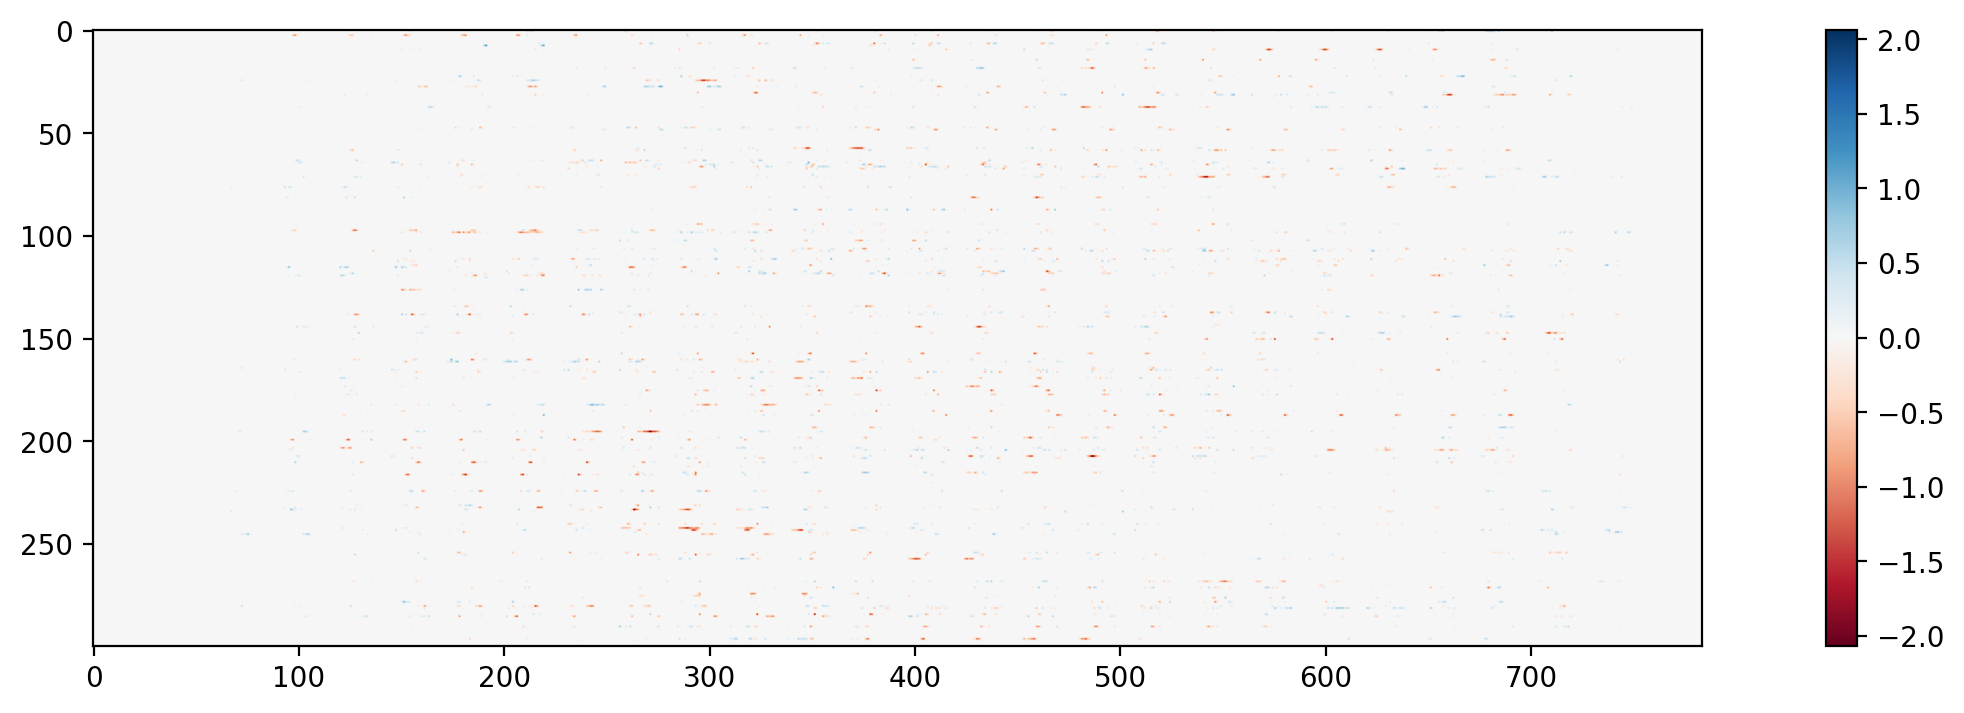

In [231]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 4
rcParams['figure.dpi'] = 200


mask = (model.fc1.log_alpha.detach().cpu().numpy() < 3).astype(np.float)
W = model.fc1.mu.detach().cpu().numpy()

# Normalize color map
max_val = np.max(np.abs(mask * W))
norm = mpl.colors.Normalize(vmin=-max_val,vmax=max_val)

plt.imshow(mask * W, cmap='RdBu', interpolation=None, norm=norm)
plt.colorbar()

(-0.5, 419.5, 419.5, -0.5)

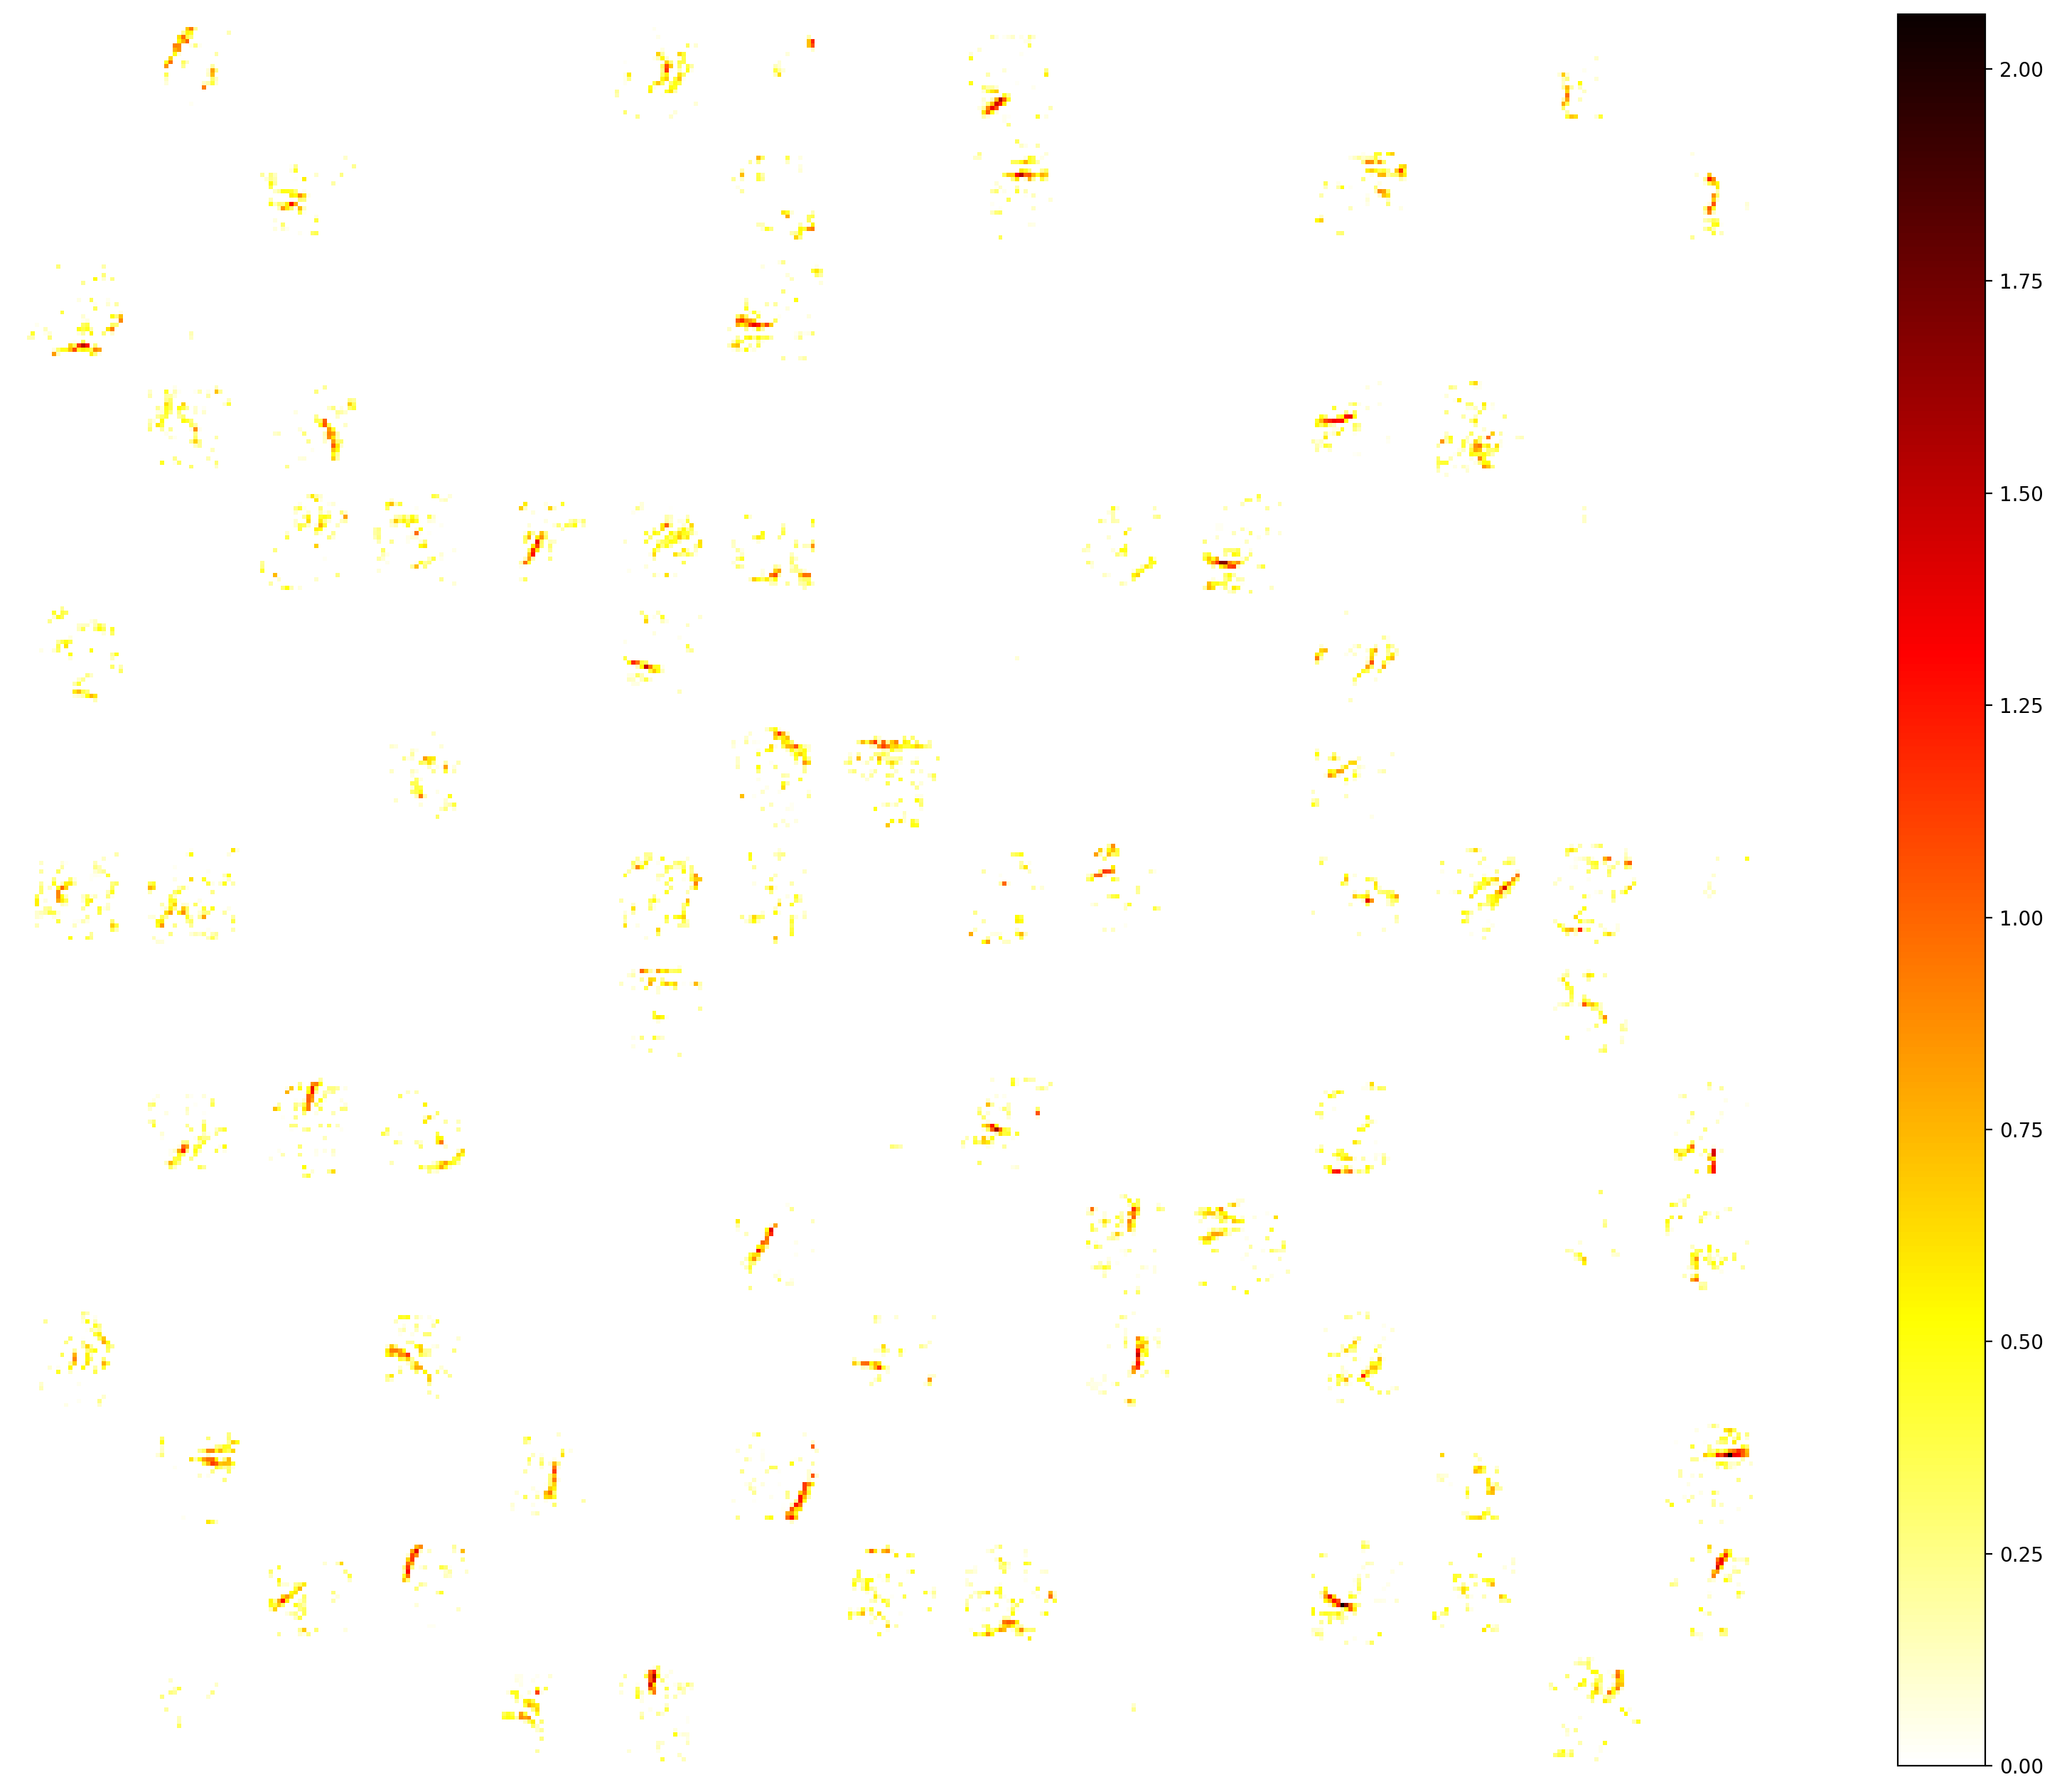

In [232]:
s = 0
z = np.zeros((28*15, 28*15))

for i in range(15):
    for j in range(15):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] = np.abs((mask * W)[s].reshape(28, 28))

plt.figure(figsize=(24, 16))
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

# Optional Research Assignment (up to 2 additional points)

1. Study the model: 
    - How sparsity and accuracy depend on maximum of KL-multiplier (kl_weight)?
    - How sparsity and accuracy depend on the initialization?
    - Study the KL: what if we optimize w.r.t. $\lambda^2$ using Adam instead of substituting the optimal $\lambda^2$?
    - How does the behaviour of optimization change if you use another parameterization for the approximate posterior? How does it affect the variance of the stochastic gradients?
2. Compression:
    - What can we do to obtain better compression results with small quality degradation?
    - Propose and eval several options.
3. Study the Local reparametrization trick: 
    - Does it really accelerate convergence?
    - Does variance of gradient decrease?
    
You can do one out of three parts. You need to provide evidence for results e.g., plots, etc.